# Predicting Car Crashes : An Analysis on the Severity of Crashes with respect to Weather and Road Condition

This project is a part of the IBM Data Science Capstone Project for August 2020. The objectives of this study is to investigate the relationship between weather and road condition on the severity of crashes within the city of Seattle. 

## Loading Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def remove_vague(df,column):
    df2 = df[df[column] != 'Unknown']
    df2 = df2[df2[column] != 'Other']
    return df2

def groupby_df(df1,column, norm = True):
    df_plot = df1.groupby([column])['SEVERITYCODE'].value_counts(normalize = norm).to_frame()
    df_plot.rename(columns={'SEVERITYCODE': 'PROBABILITY'}, inplace = True)
    prob1 = df_plot['PROBABILITY'].to_list()
    sev1 = prob1[::3]
    sev2 = prob1[1::3]
    sev3 = prob1[2::3]
    ind = np.unique(df_plot.index.get_level_values(0).values)
    df2 = pd.DataFrame({'1':sev1,'2':sev2,'3':sev3}, index =ind )
    return df2

def groupby_plot(df1,column, colors = {'1': '#5cb85c', '2': '#5bc0de', '3': '#d9534f'} ):
    dataframe = groupby_df(df1,column)
    ax = dataframe.plot(kind='bar',width = 0.8, figsize = (20,8), color = [colors[i] for i in dataframe.columns])
    ax.grid(False)
    ax.set_xticklabels(dataframe.index, fontsize=16, rotation = 0)
    ax.set_xlabel(column, fontsize = 18)
    ax.set_ylabel('Probability', fontsize = 18)
    ax.set_facecolor("white")
    ax.legend(title = "Severity Level",fontsize=14, facecolor = 'white', title_fontsize = 12)
    ax.spines['bottom'].set_color('0')
    ax.spines['bottom'].set_linewidth(1)

    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{height:.0%}', (x + width/2, y + height + 0.01), ha='center', fontsize= 14)
    return dataframe

## Loading the dataset

In [3]:
raw = pd.read_csv("Collisions.csv")
print(raw.shape)
raw.head()

(220937, 40)


,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,1.256033e+06,240501.215914,1,332176,333676,EA40602,Matched,Intersection,26581.0,28TH AVE W AND W DRAVUS ST,...,Dry,Daylight,NaN,NaN,NaN,14,From same direction - both going straight - on...,0,0,N
1,1.282438e+06,223443.774169,2,328504,330004,EA10294,Unmatched,Block,NaN,LAKE WASHINGTON BLVD BETWEEN LAKESIDE AVE AND ...,...,NaN,NaN,NaN,NaN,NaN,,NaN,0,0,Y
2,1.269233e+06,229465.525407,3,329091,330591,EA15604,Matched,Block,NaN,WESTLAKE AVE N BETWEEN DENNY WAY AND JOHN ST,...,Dry,Daylight,NaN,NaN,NaN,11,From same direction - both going straight - bo...,0,0,N
3,1.264590e+06,241958.209964,4,328274,329774,EA07215,Matched,Block,NaN,NW 36TH ST BETWEEN 1ST AVE NW AND LEARY WAY NW,...,Wet,Dark - Street Lights On,NaN,NaN,NaN,32,One parked--one moving,0,0,Y
4,1.280375e+06,271085.117386,5,329003,330503,E986969,Matched,Intersection,35990.0,30TH AVE NE AND NE 145TH ST,...,Dry,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N


In [4]:
raw.columns

Index(['X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS',
       'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC',
       'SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT',
       'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES',
       'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE',
       'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND',
       'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE',
       'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

## Selecting relevant features

In [5]:
features = ['VEHCOUNT','INJURIES','SERIOUSINJURIES','FATALITIES'\
            ,'WEATHER', 'ROADCOND','LIGHTCOND']
df = raw[features]
df.head()

,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,WEATHER,ROADCOND,LIGHTCOND
0,2,1,0,0,Overcast,Dry,Daylight
1,0,0,0,0,NaN,NaN,NaN
2,2,0,0,0,Clear,Dry,Daylight
3,4,0,0,0,Raining,Wet,Dark - Street Lights On
4,2,1,0,0,Clear,Dry,Daylight


Note that we retained VEHCOUNT,INJURIES,SERIOUSINJURIES, and FATALITIES primarily for data analysis and would not be included in our model as these features can only be determined after a car crash and not prior to it. Thus although they serve as primary features responsible for determining SEVERITYCODE - they are variables which we are unable to predict given the current data.

# Data Cleaning and Wrangling

### Binning Categorical Features From Existing Data

Upon close inspection of the dataset, we can observe that some categorical features actually have similar types and are thus redundant. It would be best to group similar features as to limit the impact of class imbalance within our dataset.

#### Weather

In [6]:
df['WEATHER'].value_counts()

Clear                       114293
Raining                      34004
Overcast                     28495
Unknown                      15131
Snowing                        919
Other                          851
Fog/Smog/Smoke                 576
Sleet/Hail/Freezing Rain       116
Blowing Sand/Dirt               56
Severe Crosswind                26
Partly Cloudy                    9
Blowing Snow                     1
Name: WEATHER, dtype: int64

As to remove the vagueness of our dataset, we can opt to remove datapoint with either Unknown or Other WEATHER. We opt to program a function to do this for all of our categorical values.

In [7]:
categ = ['WEATHER', 'ROADCOND', 'LIGHTCOND']
for c in categ:
    df = remove_vague(df,c)

We can also classify special types of weather as Extreme Weather and classify Overcast and Partly Cloudy as Cloudy Weather as these usually follow each other and are highly similar.

In [8]:
df['WEATHER'] = df['WEATHER'].replace(['Overcast','Partly Cloudy'],'Cloudy Weather')
df['WEATHER'] = df['WEATHER'].replace(['Snowing','Fog/Smog/Smoke','Sleet/Hail/Freezing Rain','Blowing Sand/Dirt','Severe Crosswind','Blowing Snow'],'Extreme Weather')
df['WEATHER'].value_counts()

Clear              112078
Raining             33525
Cloudy Weather      27734
Extreme Weather      1587
Name: WEATHER, dtype: int64

#### Road Condition

In [9]:
df['ROADCOND'].value_counts()

Dry               125239
Wet                47579
Ice                 1105
Snow/Slush           846
Standing Water       109
Sand/Mud/Dirt         68
Oil                   60
Name: ROADCOND, dtype: int64

We opted to combine oil and ice as they are all road conditions relating to a lower level traction on the road. We also opted to simply absorb sand/mud/dirt into Dry as they are mostly similar. We also decided to combine wet and standing water into one class as well as they involve the presence of water on the road.

In [10]:
df['ROADCOND'] = df['ROADCOND'].replace(['Oil','Ice'],'Oil/Ice')
df['ROADCOND'] = df['ROADCOND'].replace(['Sand/Mud/Dirt'],'Dry')
df['ROADCOND'] = df['ROADCOND'].replace(['Wet','Standing Water'],'Wet')
df['ROADCOND'].value_counts()

Dry           125307
Wet            47688
Oil/Ice         1165
Snow/Slush       846
Name: ROADCOND, dtype: int64

#### Light Condition

In [11]:
df['LIGHTCOND'].value_counts()

Daylight                    115587
Dark - Street Lights On      48334
Dusk                          5828
Dawn                          2507
Dark - No Street Lights       1445
Dark - Street Lights Off      1156
Dark - Unknown Lighting         15
Name: LIGHTCOND, dtype: int64

In [12]:
df['LIGHTCOND'] = df['LIGHTCOND'].replace(['Daylight'],'Well Lit')
df['LIGHTCOND'] = df['LIGHTCOND'].replace(['Dusk','Dawn','Dark - Street Lights On'],'Fairly Lit')
df['LIGHTCOND'] = df['LIGHTCOND'].replace(['Dark - Street Lights Off','Dark - No Street Lights','Dark - Unknown Lighting'],'Poorly Lit')
df['LIGHTCOND'].value_counts()

Well Lit      115587
Fairly Lit     56669
Poorly Lit      2616
Name: LIGHTCOND, dtype: int64

### Handling missing values in categorical data

As there is currently a high imbalance within the dataset between the most frequent class and 2nd most frequent class - we opted not to convert the nulls within our dataset to the most frequent one but rather we opted to remove them from the dataset entirely.

In [13]:
categorical = ['WEATHER','ROADCOND','LIGHTCOND']
for c in categorical:
    print(df[c].isnull().value_counts(),'\n\n')

False    174924
True      26445
Name: WEATHER, dtype: int64 


False    175006
True      26363
Name: ROADCOND, dtype: int64 


False    174872
True      26497
Name: LIGHTCOND, dtype: int64 




### Preparing Target Values

Rather than using severity code, we opted to use a new measure for determining how severe a car crash would be. Our measure uses a direct scoring system dependent on the total number of people involved per type of crash severity and not solely on the presence of an indicator.

In [14]:
df[['VEHCOUNT','INJURIES','SERIOUSINJURIES','FATALITIES']]

,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES
0,2,1,0,0
1,0,0,0,0
2,2,0,0,0
3,4,0,0,0
4,2,1,0,0
5,2,0,0,0
6,1,0,0,0
7,0,0,0,0
8,2,0,0,0
9,0,1,0,0


We can opt to measure the severity given the sum of the following arbitrary measures:
* **VEHCOUNT** (Vehicles involved in Crash) x 1
* **INJURIES** (# of People that had minor injuries due to the Crash) x 10
* **SERIOUSINJURIES** (# of People that had major injuries due to the Crash) x 100
* **FATALITIES** (# of People that died due to the Crash) x 1000

Note that these are arbitrary scoring parameters based on the importance of life. Thus a better indicator such as economic impact of the crash that would include all costs such as repair costs, hospital costs, economic damage, settlements, and the likes would serve as a good measure for severity - however as we have failed to find a suitable dataset that contains as such, we opted to favor this arbitrary scoring method which we named LIFECOST.

In [15]:
df['LIFECOST'] = df['VEHCOUNT'] + df['INJURIES']*10 + df['SERIOUSINJURIES']*100 + df['FATALITIES']*1000
df.head()

,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,WEATHER,ROADCOND,LIGHTCOND,LIFECOST
0,2,1,0,0,Cloudy Weather,Dry,Well Lit,12
1,0,0,0,0,NaN,NaN,NaN,0
2,2,0,0,0,Clear,Dry,Well Lit,2
3,4,0,0,0,Raining,Wet,Fairly Lit,4
4,2,1,0,0,Clear,Dry,Well Lit,12


In [16]:
df.describe()

,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,LIFECOST
count,201369.000000,201369.000000,201369.000000,201369.000000,201369.000000
mean,1.706991,0.401318,0.016298,0.001818,9.167573
std,0.860095,0.752999,0.164341,0.046389,53.513490
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,2.000000
50%,2.000000,0.000000,0.000000,0.000000,2.000000
75%,2.000000,1.000000,0.000000,0.000000,11.000000
max,15.000000,78.000000,41.000000,5.000000,9885.000000


In [17]:
df['LIFECOST'].value_counts()

2       95442
12      25529
0       25268
11      13093
1       11098
22       7413
3        7260
13       3341
32       1732
23       1377
111      1362
4        1312
10        954
112       680
21        609
14        593
33        520
42        498
5         269
122       268
24        264
20        182
1001      175
15        142
52        138
34        135
43        131
121       101
113        94
132        84
        ...  
1054        1
2221        1
172         1
352         1
1441        1
442         1
2021        1
90          1
613         1
554         1
99          1
4005        1
29          1
1563        1
175         1
49          1
1331        1
351         1
9885        1
665         1
1256        1
105         1
3001        1
1336        1
441         1
362         1
235         1
363         1
1043        1
1023        1
Name: LIFECOST, Length: 197, dtype: int64

As you might observe, there is a wide range of values for LIFECOST and is highly spreadout with larger values having the least amount of datapoints. We therefore bin these values such that we can have a better view of the dataset structure.

In [18]:
def bin_cost(x):
    if x <= 9: #Indicates mostly Property Damage
        return 0
    elif (x>9) and (x<=50): #Indicates Minor Crash involving some injuries
        return 1
    elif (x>50) and (x<=100): #Indicates a Severe Crash with multiple people having minor injuries
        return 2
    elif (x>100) and (x<=500): #Indicates a Major Crash with major injuries
        return 3
    elif (x>500) and (x<=2000): #Indicates a Major Crash with major injuries and death
        return 4
    elif (x>2000): #Indicates a Massive Crash with multiple deaths
        return 5

In [19]:
df['LIFECOSTSCORE'] = df['LIFECOST'].apply(bin_cost)
df.head()

,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,WEATHER,ROADCOND,LIGHTCOND,LIFECOST,LIFECOSTSCORE
0,2,1,0,0,Cloudy Weather,Dry,Well Lit,12,1
1,0,0,0,0,NaN,NaN,NaN,0,0
2,2,0,0,0,Clear,Dry,Well Lit,2,0
3,4,0,0,0,Raining,Wet,Fairly Lit,4,0
4,2,1,0,0,Clear,Dry,Well Lit,12,1


In [20]:
df['LIFECOSTSCORE'].value_counts()

0    140772
1     56886
3      2990
2       374
4       331
5        16
Name: LIFECOSTSCORE, dtype: int64

### Removing null values

In [21]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174720 entries, 0 to 220933
Data columns (total 9 columns):
VEHCOUNT           174720 non-null int64
INJURIES           174720 non-null int64
SERIOUSINJURIES    174720 non-null int64
FATALITIES         174720 non-null int64
WEATHER            174720 non-null object
ROADCOND           174720 non-null object
LIGHTCOND          174720 non-null object
LIFECOST           174720 non-null int64
LIFECOSTSCORE      174720 non-null int64
dtypes: int64(6), object(3)
memory usage: 13.3+ MB


# Initial Data Analysis

We investigate how frequent do accidents occur given the ideal conditions for a driving (clear weather, sufficient lighting, dry road).

In [22]:
df_ideal = df[(df['WEATHER'] == 'Clear') & (df['ROADCOND'] == 'Dry') & (df['LIGHTCOND'] == 'Well Lit')]
df_ideal.head()

,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,WEATHER,ROADCOND,LIGHTCOND,LIFECOST,LIFECOSTSCORE
2,2,0,0,0,Clear,Dry,Well Lit,2,0
4,2,1,0,0,Clear,Dry,Well Lit,12,1
5,2,0,0,0,Clear,Dry,Well Lit,2,0
12,2,1,0,0,Clear,Dry,Well Lit,12,1
16,2,0,0,0,Clear,Dry,Well Lit,2,0


In [23]:
df_ideal['LIFECOSTSCORE'].value_counts(normalize = 'True')

0    0.649560
1    0.330289
3    0.016392
2    0.002131
4    0.001576
5    0.000052
Name: LIFECOSTSCORE, dtype: float64

We investigate the distribution with respect to severity of car crashes within ideal conditions

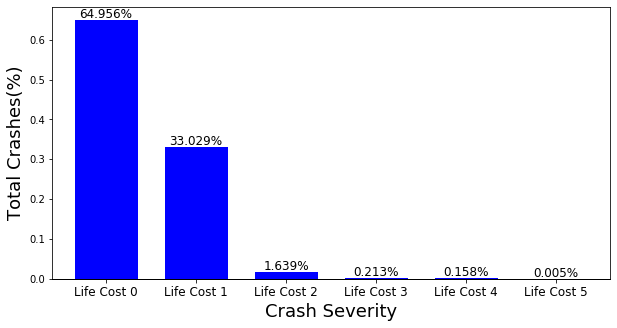

In [24]:
#df_ideal['SEVERITYCODE'].value_counts(normalize=True).plot(kind='bar', figsize = (20,8))

ax = df_ideal['LIFECOSTSCORE'].value_counts(normalize = True).plot(kind='bar', figsize = (10,5), width = 0.7, color = 'b')
ax.grid(False)
ax.set_xticklabels(['Life Cost 0','Life Cost 1','Life Cost 2','Life Cost 3','Life Cost 4','Life Cost 5'],fontsize=12, rotation = 0)
ax.set_xlabel('Crash Severity', fontsize = 18)
ax.set_ylabel('Total Crashes(%)', fontsize = 18)
ax.set_facecolor("white")
#ax.legend(title = "Severity Level",fontsize=14, facecolor = 'white', title_fontsize = 12)
ax.spines['bottom'].set_color('0')
ax.spines['bottom'].set_linewidth(1)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.3%}', (x + width/2, y + height + 0.005), ha='center', fontsize= 12)

We then compare it with non ideal conditions to assess the difference between the ideal conditions and not so ideal conditions

In [25]:
df_worse = df[(df['WEATHER'] != 'Clear') | (df['ROADCOND'] != 'Dry') | (df['LIGHTCOND'] != 'Well Lit')]
df_worse.head()

,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,WEATHER,ROADCOND,LIGHTCOND,LIFECOST,LIFECOSTSCORE
0,2,1,0,0,Cloudy Weather,Dry,Well Lit,12,1
3,4,0,0,0,Raining,Wet,Fairly Lit,4,0
6,1,0,0,0,Clear,Dry,Fairly Lit,1,0
8,2,0,0,0,Raining,Wet,Well Lit,2,0
10,2,0,0,0,Clear,Dry,Fairly Lit,2,0


In [26]:
df_worse['LIFECOSTSCORE'].value_counts(normalize = 'True')

0    0.667420
1    0.310751
3    0.017533
2    0.002138
4    0.002035
5    0.000123
Name: LIFECOSTSCORE, dtype: float64

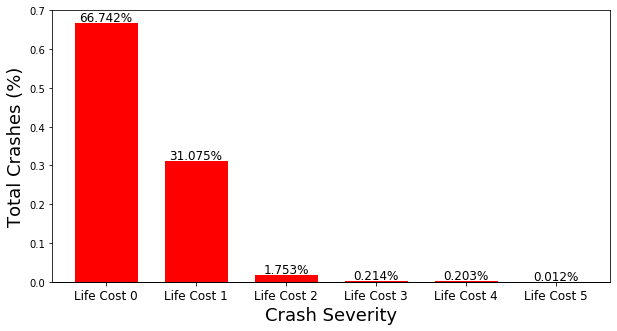

In [27]:
#df_ideal['SEVERITYCODE'].value_counts(normalize=True).plot(kind='bar', figsize = (20,8))

ax = df_worse['LIFECOSTSCORE'].value_counts(normalize = True).plot(kind='bar', figsize = (10,5), width = 0.7, color = 'r')
ax.grid(False)
ax.set_xticklabels(['Life Cost 0','Life Cost 1','Life Cost 2','Life Cost 3','Life Cost 4','Life Cost 5'],fontsize=12, rotation = 0)
ax.set_xlabel('Crash Severity', fontsize = 18)
ax.set_ylabel('Total Crashes (%)', fontsize = 18)
ax.set_facecolor("white")
#ax.legend(title = "Severity Level",fontsize=14, facecolor = 'white', title_fontsize = 12)
ax.spines['bottom'].set_color('0')
ax.spines['bottom'].set_linewidth(1)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.3%}', (x + width/2, y + height + 0.005), ha='center', fontsize= 12)

We see that although ideal conditions were present, there were still a number of accidents that occured. The reason why may not be captured by our dataset, however we can hypothesize that this is mainly due to human error or due to mechanical issues. Although the pattern is similar for both situations given data from a minor crash up to major crash, we can see a major shift when it is in respect to massive crashes and above. We can see that more crashes are involved in those involved with multiple major injuries and death under non-ideal weather conditions, effectively doubling for crashes with multiple deaths and a 20% increase for those with multiple major injuries and death.

### Injuries and Road and Weather Conditions

We hypothesize that injuries and more severe injuries should occur during unideal conditions.

In [28]:
print('----Ideal Conditions')
print('Injuries:', df_ideal['INJURIES'].sum())
print('Serious Injuries: ',df_ideal['SERIOUSINJURIES'].sum())
print('----Non-Ideal Conditions')
print('Injuries:', df_worse['INJURIES'].sum())
print('Serious Injuries: ',df_worse['SERIOUSINJURIES'].sum())

----Ideal Conditions
Injuries: 36120
Serious Injuries:  1386
----Non-Ideal Conditions
Injuries: 43338
Serious Injuries:  1879


In [29]:
print('Increase in Injuries: ',(43338-36120)/(36120+43338))
print('Increase in Serious Injuries: ',(1879-1386)/(1879+1386))

Increase in Injuries:  0.09084044400815525
Increase in Serious Injuries:  0.15099540581929555


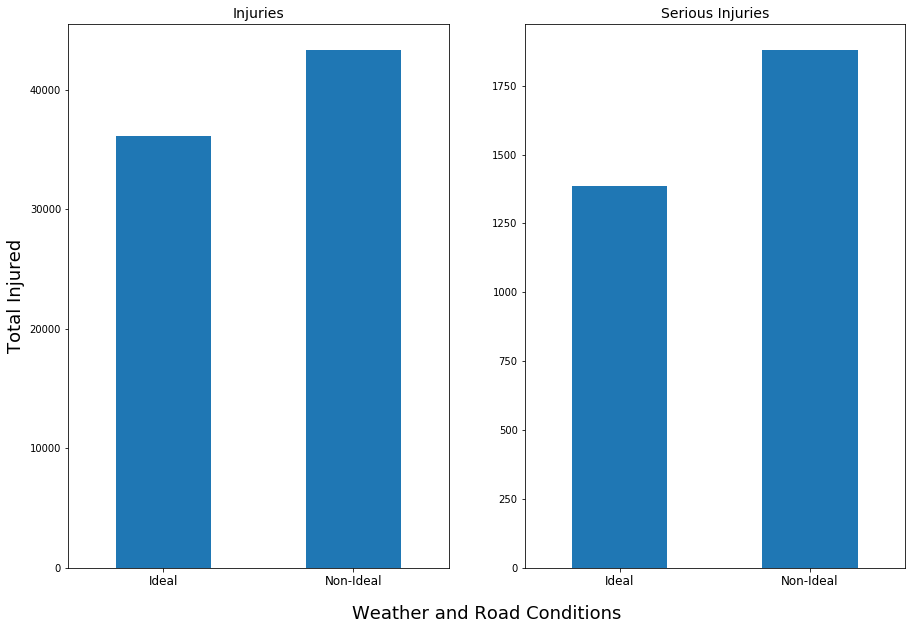

In [30]:
df_injuries = pd.DataFrame({'Injuries':[36120,43338],'Serious Injuries':[1386,1879]},index = ['Ideal','Non-Ideal'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
df_injuries['Injuries'].plot(kind='bar', ax = ax1)
df_injuries['Serious Injuries'].plot(kind='bar', ax = ax2)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Weather and Road Conditions", fontsize = 18, labelpad = 20)
plt.ylabel("Total Injured", fontsize = 18, labelpad = 20)

ax1.set_title("Injuries", fontsize =  14)
ax1.set_xticklabels(['Ideal','Non-Ideal'],fontsize=12, rotation = 0)
ax1.set_facecolor("white")

ax2.set_title("Serious Injuries", fontsize =  14)
ax2.set_xticklabels(['Ideal','Non-Ideal'],fontsize=12, rotation = 0)
ax2.set_facecolor("white")

### Deaths and Road and Weather Conditions

In [31]:
print('----Ideal Conditions')
print('Deaths:', df_ideal['FATALITIES'].sum())
print('----Non-Ideal Conditions')
print('Deaths:', df_worse['FATALITIES'].sum())

----Ideal Conditions
Deaths: 131
----Non-Ideal Conditions
Deaths: 224


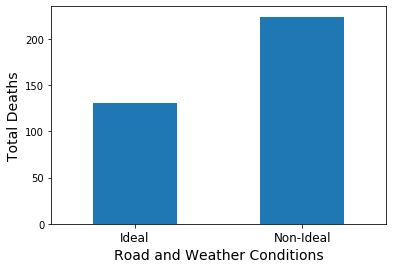

In [32]:
df_injuries = pd.DataFrame({'Deaths':[131,224],},index = ['Ideal','Non-Ideal'])

ax = df_injuries['Deaths'].plot(kind='bar')
#ax.set_title("Deaths", fontsize =  14)
ax.set_ylabel('Total Deaths', fontsize = 14)
ax.set_xlabel('Road and Weather Conditions', fontsize = 14)
ax.set_xticklabels(['Ideal','Non-Ideal'],fontsize=12, rotation = 0)
ax.set_facecolor("white")

In [33]:
print('Increase in Deaths: ',(224-131)/(224+131))

Increase in Deaths:  0.2619718309859155


### Deaths and Injuries with respect to Non-Ideal Weather

In [34]:
df_niw = df_worse[df_worse['WEATHER'] !='Clear']

print('Injuries:', df_niw.groupby(['WEATHER'])['INJURIES'].sum())
print('Major Injuries:', df_niw.groupby(['WEATHER'])['SERIOUSINJURIES'].sum())
print('Deaths:', df_niw.groupby(['WEATHER'])['FATALITIES'].sum())

Injuries: WEATHER
Cloudy Weather     12262
Extreme Weather      537
Raining            15727
Name: INJURIES, dtype: int64
Major Injuries: WEATHER
Cloudy Weather     493
Extreme Weather     17
Raining            563
Name: SERIOUSINJURIES, dtype: int64
Deaths: WEATHER
Cloudy Weather     55
Extreme Weather     5
Raining            53
Name: FATALITIES, dtype: int64


In [35]:
cw = [12262/43338,492/1879,55/(224)] 
ex = [537/43338,17/1879,5/(224)]
ra = [15727/43338,563/1879,53/(224)]
df_id_niw = pd.DataFrame({'Rain':ra,'Cloudy Weather':cw,'Extreme Weather':ex},index = ['Injuries','Major Injuries','Deaths'])
df_id_niw

,Rain,Cloudy Weather,Extreme Weather
Injuries,0.362892,0.282939,0.012391
Major Injuries,0.299627,0.261841,0.009047
Deaths,0.236607,0.245536,0.022321


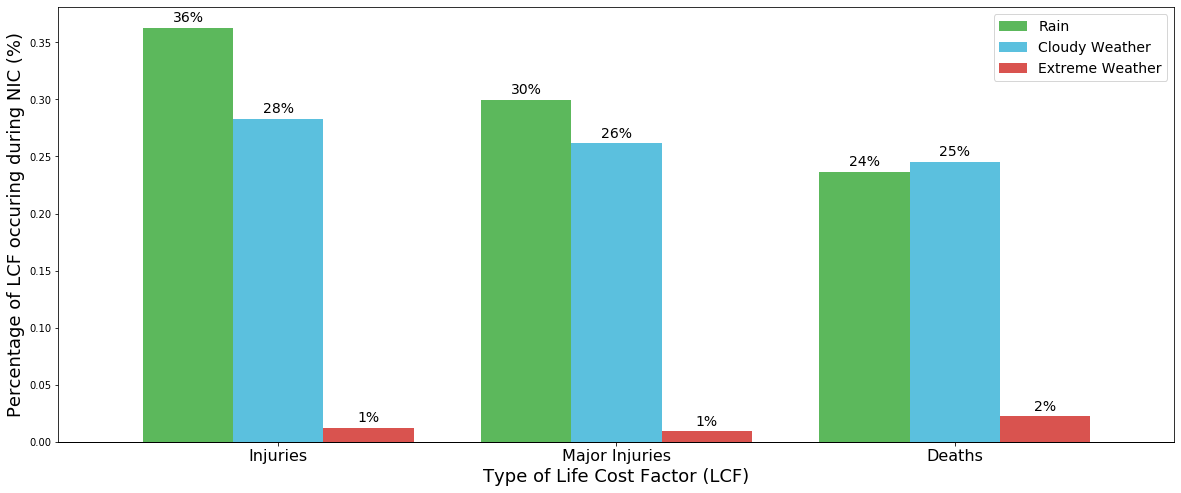

In [36]:
colors = {'Rain': '#5cb85c', 'Cloudy Weather': '#5bc0de', 'Extreme Weather': '#d9534f'} 
ax = df_id_niw.plot(kind='bar',width = 0.8, figsize = (20,8), color = [colors[i] for i in df_id_niw.columns])
ax.grid(False)
ax.set_xticklabels(df_id_niw.index, fontsize=16, rotation = 0)
ax.set_xlabel('Type of Life Cost Factor (LCF)', fontsize = 18)
ax.set_ylabel('Percentage of LCF occuring during NIC (%)', fontsize = 18)
ax.set_facecolor("white")
ax.legend(fontsize=14, facecolor = 'white', title_fontsize = 12)
ax.spines['bottom'].set_color('0')
ax.spines['bottom'].set_linewidth(1)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.0%}', (x + width/2, y + height + 0.005), ha='center', fontsize= 14)


### Deaths and Injuries with respect to Non-Ideal Road Conditions

In [37]:
df_nir = df_worse[df_worse['ROADCOND'] !='Dry']

print('Injuries:', df_nir.groupby(['ROADCOND'])['INJURIES'].sum())
print('Major Injuries:', df_nir.groupby(['ROADCOND'])['SERIOUSINJURIES'].sum())
print('Deaths:', df_nir.groupby(['ROADCOND'])['FATALITIES'].sum())

Injuries: ROADCOND
Oil/Ice         415
Snow/Slush      219
Wet           22036
Name: INJURIES, dtype: int64
Major Injuries: ROADCOND
Oil/Ice        20
Snow/Slush      7
Wet           810
Name: SERIOUSINJURIES, dtype: int64
Deaths: ROADCOND
Oil/Ice        1
Snow/Slush     0
Wet           71
Name: FATALITIES, dtype: int64


In [38]:
oi = [415/43338,20/1879,1/(224)] 
ss = [219/43338,7/1879,0/(224)]
w = [22036/43338,810/1879,71/(224)]
df_id_nir = pd.DataFrame({'Wet':w,'Snow/Slush':ss,'Oil/Ice':oi},index = ['Injuries','Major Injuries','Deaths'])
df_id_nir

,Wet,Snow/Slush,Oil/Ice
Injuries,0.508468,0.005053,0.009576
Major Injuries,0.431080,0.003725,0.010644
Deaths,0.316964,0.000000,0.004464


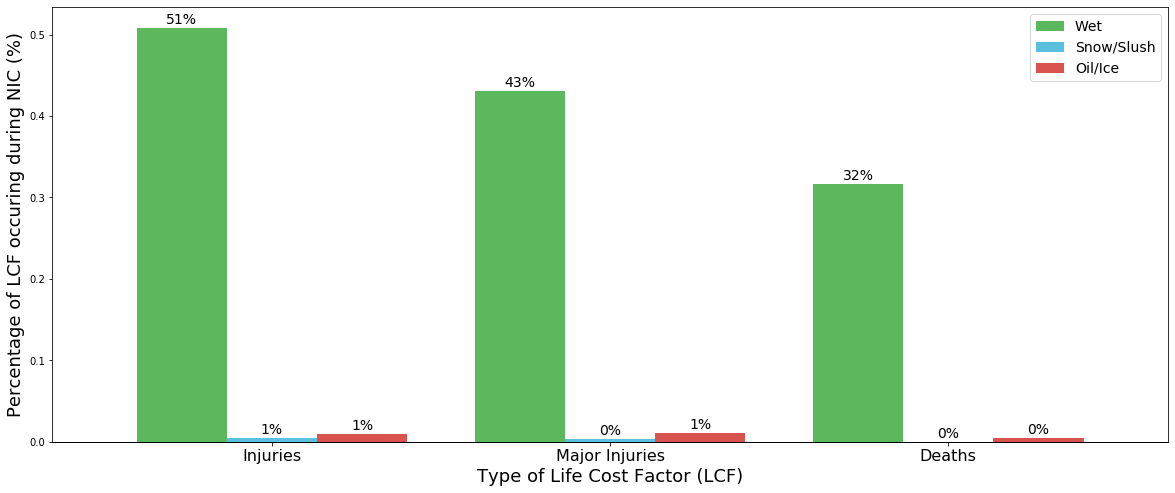

In [39]:
colors = {'Wet': '#5cb85c', 'Snow/Slush': '#5bc0de', 'Oil/Ice': '#d9534f'} 
ax = df_id_nir.plot(kind='bar',width = 0.8, figsize = (20,8), color = [colors[i] for i in df_id_nir.columns])
ax.grid(False)
ax.set_xticklabels(df_id_nir.index, fontsize=16, rotation = 0)
ax.set_xlabel('Type of Life Cost Factor (LCF)', fontsize = 18)
ax.set_ylabel('Percentage of LCF occuring during NIC (%)', fontsize = 18)
ax.set_facecolor("white")
ax.legend(fontsize=14, facecolor = 'white', title_fontsize = 12)
ax.spines['bottom'].set_color('0')
ax.spines['bottom'].set_linewidth(1)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.0%}', (x + width/2, y + height + 0.005), ha='center', fontsize= 14)


### Deaths and Injuries with respect to Non-Ideal Light Conditions

In [40]:
df_nil = df_worse[df_worse['LIGHTCOND'] !='Well Lit']

print('Injuries:', df_nil.groupby(['LIGHTCOND'])['INJURIES'].sum())
print('Major Injuries:', df_nil.groupby(['LIGHTCOND'])['SERIOUSINJURIES'].sum())
print('Deaths:', df_nil.groupby(['LIGHTCOND'])['FATALITIES'].sum())

Injuries: LIGHTCOND
Fairly Lit    24751
Poorly Lit      936
Name: INJURIES, dtype: int64
Major Injuries: LIGHTCOND
Fairly Lit    1287
Poorly Lit      56
Name: SERIOUSINJURIES, dtype: int64
Deaths: LIGHTCOND
Fairly Lit    176
Poorly Lit      4
Name: FATALITIES, dtype: int64


In [41]:
fl = [24751/43338,1287/1879,176/(224)] 
pl = [936/43338,56/1879,4/(224)]
df_id_nil = pd.DataFrame({'Fairly Lit':fl,'Poorly Lit':pl},index = ['Injuries','Major Injuries','Deaths'])
df_id_nil

,Fairly Lit,Poorly Lit
Injuries,0.571115,0.021598
Major Injuries,0.684939,0.029803
Deaths,0.785714,0.017857


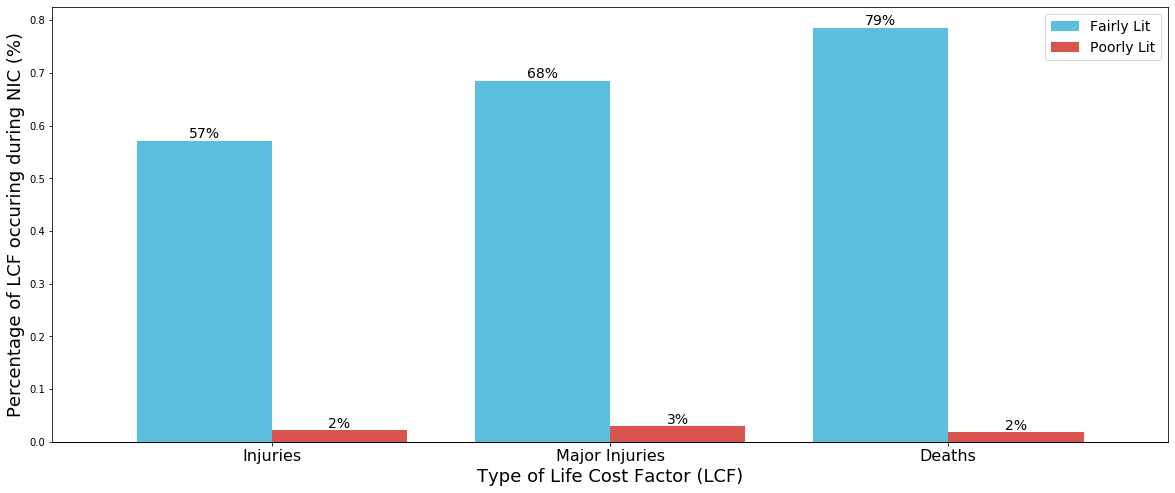

In [42]:
colors = {'Fairly Lit': '#5bc0de', 'Poorly Lit': '#d9534f'} 
ax = df_id_nil.plot(kind='bar',width = 0.8, figsize = (20,8), color = [colors[i] for i in df_id_nil.columns])
ax.grid(False)
ax.set_xticklabels(df_id_nil.index, fontsize=16, rotation = 0)
ax.set_xlabel('Type of Life Cost Factor (LCF)', fontsize = 18)
ax.set_ylabel('Percentage of LCF occuring during NIC (%)', fontsize = 18)
ax.set_facecolor("white")
ax.legend(fontsize=14, facecolor = 'white', title_fontsize = 12)
ax.spines['bottom'].set_color('0')
ax.spines['bottom'].set_linewidth(1)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.0%}', (x + width/2, y + height + 0.005), ha='center', fontsize= 14)


## Predictive Modeling

In [43]:
df_worse.head()

,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,WEATHER,ROADCOND,LIGHTCOND,LIFECOST,LIFECOSTSCORE
0,2,1,0,0,Cloudy Weather,Dry,Well Lit,12,1
3,4,0,0,0,Raining,Wet,Fairly Lit,4,0
6,1,0,0,0,Clear,Dry,Fairly Lit,1,0
8,2,0,0,0,Raining,Wet,Well Lit,2,0
10,2,0,0,0,Clear,Dry,Fairly Lit,2,0


In [44]:
X = pd.get_dummies(df_worse[['WEATHER','ROADCOND','LIGHTCOND']],drop_first = True)
y = df_worse['LIFECOSTSCORE']

In [45]:
X

,WEATHER_Cloudy Weather,WEATHER_Extreme Weather,WEATHER_Raining,ROADCOND_Oil/Ice,ROADCOND_Snow/Slush,ROADCOND_Wet,LIGHTCOND_Poorly Lit,LIGHTCOND_Well Lit
0,1,0,0,0,0,0,0,1
3,0,0,1,0,0,1,0,0
6,0,0,0,0,0,0,0,0
8,0,0,1,0,0,1,0,1
10,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
220927,1,0,0,0,0,0,0,1
220929,0,0,1,0,0,1,0,0
220930,1,0,0,0,0,0,0,1
220931,0,0,1,0,0,1,0,1


In [46]:
X.columns

Index(['WEATHER_Cloudy Weather', 'WEATHER_Extreme Weather', 'WEATHER_Raining',
       'ROADCOND_Oil/Ice', 'ROADCOND_Snow/Slush', 'ROADCOND_Wet',
       'LIGHTCOND_Poorly Lit', 'LIGHTCOND_Well Lit'],
      dtype='object')

# K Nearest Neighbor(KNN)

In [48]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tqdm import tqdm

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.155, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (82221, 8) (82221,)
Test set: (15082, 8) (15082,)


## Searching for most accurate k value

In [48]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in tqdm(range(1,Ks)):
     
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [07:50<00:00, 52.31s/it]


array([0.64328338, 0.65349423, 0.6513725 , 0.65223445, 0.64951598,
       0.65243336, 0.65243336, 0.67557353, 0.67404853])

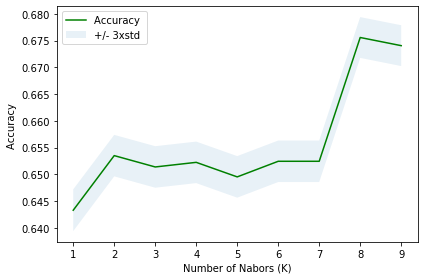

In [49]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [50]:
KNN_model = KNeighborsClassifier(n_neighbors = 8).fit(X_train,y_train)

# Decision Tree

In [51]:
from sklearn.tree import DecisionTreeClassifier

decisionTree = DecisionTreeClassifier(criterion="entropy", max_depth = 20).fit(X_train,y_train)

# Support vector machines

In [52]:
from sklearn import svm
kernels = ['rbf','linear','poly','sigmoid']
for kern in tqdm(kernels):
    SVM_model = svm.SVC(kernel = kern).fit(X_train,y_train)
    yhat = SVM_model.predict(X_test)
    acc = metrics.accuracy_score(y_test,yhat)
    print(f'The accuracy of the SVM with kernel = {kern} is equal to {acc}') #


 25%|████████████████████▊                                                              | 1/4 [06:08<18:24, 368.11s/it]

The accuracy of the SVM with kernel = rbf is equal to 0.6755735313618884


 50%|█████████████████████████████████████████▌                                         | 2/4 [10:13<11:02, 331.21s/it]

The accuracy of the SVM with kernel = linear is equal to 0.6755735313618884


 75%|██████████████████████████████████████████████████████████████▎                    | 3/4 [16:26<05:43, 343.72s/it]

The accuracy of the SVM with kernel = poly is equal to 0.6755735313618884


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [31:40<00:00, 475.08s/it]

The accuracy of the SVM with kernel = sigmoid is equal to 0.5944834902532821


In [58]:
clf = svm.SVC(kernel = 'rbf', probability = True).fit(X_train,y_train)

# Logistic Regression

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

params1 = [{'C':[1,0.1,0.01,0.001,0.0001],
           'solver':['liblinear', 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
           }]
LR = LogisticRegression()
LR_Grid = GridSearchCV(LR, params1,cv=4)
LR_Grid.fit(X_train,y_train) 

In [54]:
print(f'Grid Search yielded the best score for logistic regression as : {LR_Grid.best_score_} with parameters : {LR_Grid.best_params_}')

Grid Search yielded the best score for logistic regression as : 0.6659247641899159 with parameters : {'C': 1, 'solver': 'liblinear'}


In [49]:
LR_model = LogisticRegression(C = 1, solver ='liblinear').fit(X_train, y_train)

D:\Downloads\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


## Evaluating the Models with Test Set

In [50]:
#k-Nearest Neighbors
yhat_knn = KNN_model.predict(X_test)
prob_knn = KNN_model.predict_proba(X_test)

#Decision Tree
yhat_dt = decisionTree.predict(X_test)
prob_dt = decisionTree.predict_proba(X_test)

#SVM
yhat_svm = clf.predict(X_test)
prob_svm = clf.predict_proba(X_test)

#Logistic Regression
yhat_lr = LR_model.predict(X_test)
prob_lr = LR_model.predict_proba(X_test)

In [62]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

yhats = [yhat_knn,yhat_dt,yhat_svm,yhat_lr]
probs = [prob_knn,prob_dt,prob_svm,prob_lr]
scores = []
for i in range(len(probs)):
    s1 = jaccard_similarity_score(y_test,yhats[i])
    s2 = f1_score(y_test,yhats[i], average='weighted')
    s3 = log_loss(y_test,probs[i])
    sc = [s1,s2,s3]
    scores.append(sc)


names = ['K-Nearest Neighbors', 'Decision Tree', 'SVM', 'Logistic Regression']
for i in range(len(names)):
    print(f'{names[i]}')
    print('\t Jaccard Score: {:.3f}'.format(scores[i][0]))
    print('\t F1-Score: {:.3f}'.format(scores[i][1]))
    print('\t Log-Loss: {:.3f}'.format(scores[i][2]))    

K-Nearest Neighbors
	 Jaccard Score: 0.676
	 F1-Score: 0.545
	 Log-Loss: 2.645
Decision Tree
	 Jaccard Score: 0.676
	 F1-Score: 0.545
	 Log-Loss: 0.723
SVM
	 Jaccard Score: 0.676
	 F1-Score: 0.545
	 Log-Loss: 0.722
Logistic Regression
	 Jaccard Score: 0.676
	 F1-Score: 0.545
	 Log-Loss: 0.718


D:\Downloads\Anaconda3\envs\sgraph\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
D:\Downloads\Anaconda3\envs\sgraph\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
D:\Downloads\Anaconda3\envs\sgraph\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
D:\Down

In [51]:
#Ideal Weather, #Cloudy Weather #Extreme Weather #Raining #Oil/Ice #Snow/Slush #Wet #Poorly Lit #Well Lit
solo_conditions = [[0,0,0,0,0,0,0,0],
[1,0,0,1,0,0,1,0],
[0,1,0,0,0,0,0,0],
[0,0,1,0,0,0,0,0],
[0,0,0,1,0,0,0,0], 
[0,0,0,0,1,0,0,0], 
[0,0,0,0,0,1,0,0], 
[0,0,0,0,0,0,1,0],
[0,0,0,0,0,0,0,1]] 
solo_conditions

[[0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 1, 0, 0, 1, 0],
 [0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 1]]

In [52]:
cond = ['Ideal Weather', 'Cloudy Weather', 'Extreme Weather', 'Raining', 'Oil/Ice', 'Snow/Slush', 'Wet', 'Poorly Lit', 'Well Lit']
pred_solo = []
for i in range(len(solo_conditions)):
    x = np.reshape(solo_conditions[i],(1,-1))
    pred = LR_model.predict_proba(x)
    pred = pred*100
    pred_solo.append(pred)
    print(f'Under {cond[i]} the chances of accidents of the varying severity levels are:')
    count = 0
    for p in pred[0]:
        print('\t\tLIFECOST {}: {:.2f}'.format(count,p))
        count+=1

        

Under Ideal Weather the chances of accidents of the varying severity levels are:
		LIFECOST 0: 67.63
		LIFECOST 1: 29.60
		LIFECOST 2: 0.26
		LIFECOST 3: 2.13
		LIFECOST 4: 0.34
		LIFECOST 5: 0.05
Under Cloudy Weather the chances of accidents of the varying severity levels are:
		LIFECOST 0: 78.84
		LIFECOST 1: 18.73
		LIFECOST 2: 0.06
		LIFECOST 3: 2.21
		LIFECOST 4: 0.15
		LIFECOST 5: 0.01
Under Extreme Weather the chances of accidents of the varying severity levels are:
		LIFECOST 0: 68.55
		LIFECOST 1: 29.52
		LIFECOST 2: 0.12
		LIFECOST 3: 1.31
		LIFECOST 4: 0.43
		LIFECOST 5: 0.07
Under Raining the chances of accidents of the varying severity levels are:
		LIFECOST 0: 66.43
		LIFECOST 1: 30.75
		LIFECOST 2: 0.39
		LIFECOST 3: 2.06
		LIFECOST 4: 0.34
		LIFECOST 5: 0.03
Under Oil/Ice the chances of accidents of the varying severity levels are:
		LIFECOST 0: 73.62
		LIFECOST 1: 23.93
		LIFECOST 2: 0.10
		LIFECOST 3: 2.11
		LIFECOST 4: 0.20
		LIFECOST 5: 0.04
Under Snow/Slush the cha

As you might observe, as there is a significantly larger amount of accidents that only deal with property damage, all our models are highly biased towards accidents with a LIFECOST of 1. There also exists a significant number of car crashes in our dataset that only contained minor crashes that involved minor injuries and are classified with a LIFECOST of 2. As they are extremely commmon, our machine learning models are highly biased towards them. 

To resolve this issue, we attempt to train our model on only datapoints with LIFECOST 3 and above.

# Selective Modeling

In [53]:
df_worst = df_worse[df_worse['LIFECOSTSCORE'] >= 2]
X = pd.get_dummies(df_worst[['WEATHER','ROADCOND','LIGHTCOND']],drop_first = True)
y = df_worst['LIFECOSTSCORE']
print(np.unique(y))

[2 3 4 5]


In [54]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.155, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (1794, 8) (1794,)
Test set: (330, 8) (330,)


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 26.11it/s]


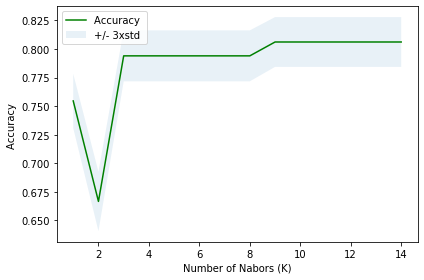

In [132]:
#KNN
Ks = 15
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in tqdm(range(1,Ks)):
     
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [133]:
#Decision Tree
decisionTree = DecisionTreeClassifier(criterion="entropy", max_depth = 20).fit(X_train,y_train)

In [134]:
#Support Vector Machine
kernels = ['rbf','linear','poly','sigmoid']
for kern in tqdm(kernels):
    SVM_model = svm.SVC(kernel = kern).fit(X_train,y_train)
    yhat = SVM_model.predict(X_test)
    acc = metrics.accuracy_score(y_test,yhat)
    print(f'The accuracy of the SVM with kernel = {kern} is equal to {acc}') #

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 16.73it/s]

The accuracy of the SVM with kernel = rbf is equal to 0.806060606060606
The accuracy of the SVM with kernel = linear is equal to 0.806060606060606
The accuracy of the SVM with kernel = poly is equal to 0.806060606060606
The accuracy of the SVM with kernel = sigmoid is equal to 0.7636363636363637


In [135]:
#Logistic regression 
params1 = [{'C':[1,0.1,0.01,0.001,0.0001],
            'solver':['liblinear', 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
           }]
LR = LogisticRegression()
LR_Grid = GridSearchCV(LR, params1,cv=4)
LR_Grid.fit(X_train,y_train) 
print(f'Grid Search yielded the best score for logistic regression as : {LR_Grid.best_score_} with parameters : {LR_Grid.best_params_}')

Grid Search yielded the best score for logistic regression as : 0.8026765828825964 with parameters : {'C': 1, 'solver': 'liblinear'}


In [55]:
#KNN_model = KNeighborsClassifier(n_neighbors = 9).fit(X_train,y_train)
#DT_model = DecisionTreeClassifier(criterion="entropy", max_depth = 20).fit(X_train,y_train)
#clf_model = svm.SVC(kernel = 'linear', probability = True).fit(X_train,y_train)
LR_model = LogisticRegression(C = 1, solver='liblinear').fit(X_train,y_train)

D:\Downloads\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [56]:
#k-Nearest Neighbors
yhat_knn = KNN_model.predict(X_test)
prob_knn = KNN_model.predict_proba(X_test)

#Decision Tree
yhat_dt = DT_model.predict(X_test)
prob_dt = DT_model.predict_proba(X_test)

#SVM
yhat_svm = clf_model.predict(X_test)
prob_svm = clf_model.predict_proba(X_test)

#Logistic Regression
yhat_lr = LR_model.predict(X_test)
prob_lr = LR_model.predict_proba(X_test)

In [138]:
yhats = [yhat_knn,yhat_dt,yhat_svm,yhat_lr]
probs = [prob_knn,prob_dt,prob_svm,prob_lr]
scores = []
for i in range(len(probs)):
    s1 = jaccard_similarity_score(y_test,yhats[i])
    s2 = f1_score(y_test,yhats[i], average='weighted')
    s3 = log_loss(y_test,probs[i])
    sc = [s1,s2,s3]
    scores.append(sc)


names = ['K-Nearest Neighbors', 'Decision Tree', 'SVM', 'Logistic Regression']
for i in range(len(names)):
    print(f'{names[i]}')
    print('\t Jaccard Score: {:.3f}'.format(scores[i][0]))
    print('\t F1-Score: {:.3f}'.format(scores[i][1]))
    print('\t Log-Loss: {:.3f}'.format(scores[i][2]))    

K-Nearest Neighbors
	 Jaccard Score: 0.806
	 F1-Score: 0.720
	 Log-Loss: 3.945
Decision Tree
	 Jaccard Score: 0.806
	 F1-Score: 0.720
	 Log-Loss: 0.743
SVM
	 Jaccard Score: 0.806
	 F1-Score: 0.720
	 Log-Loss: 0.667
Logistic Regression
	 Jaccard Score: 0.806
	 F1-Score: 0.720
	 Log-Loss: 0.654


D:\Downloads\Anaconda3\envs\sgraph\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
D:\Downloads\Anaconda3\envs\sgraph\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
D:\Downloads\Anaconda3\envs\sgraph\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)
D:\Down

In [139]:
solo_conditions = [
[0,0,0,0,0,0,0,1],
[1,0,0,0,0,0,0,0],
[0,1,0,0,0,0,0,0],
[0,0,1,0,0,0,0,0],
[0,0,0,1,0,0,0,0], 
[0,0,0,0,1,0,0,0], 
[0,0,0,0,0,1,0,0], 
[0,0,0,0,0,0,1,0],
[0,0,0,0,0,0,0,0]] 

In [57]:
cond = ['Ideal Weather', 'Cloudy Weather', 'Extreme Weather', 'Raining', 'Oil/Ice', 'Snow/Slush', 'Wet', 'Poorly Lit', 'Fairly Lit']
pred_solo = []
for i in range(len(solo_conditions)):
    x = np.reshape(solo_conditions[i],(1,-1))
    pred = LR_model.predict_proba(x)
    pred = pred*100
    pred_solo.append(pred)
    print(f'Under {cond[i]} the chances of severe and massive car crashes of varying levels are:')
    count = 2
    for p in pred[0]:
        print('\t\tLIFECOST {}: {:.2f}'.format(count,p))
        count+=1

Under Ideal Weather the chances of severe and massive car crashes of varying levels are:
		LIFECOST 2: 8.58
		LIFECOST 3: 78.54
		LIFECOST 4: 11.64
		LIFECOST 5: 1.24
Under Cloudy Weather the chances of severe and massive car crashes of varying levels are:
		LIFECOST 2: 2.33
		LIFECOST 3: 91.30
		LIFECOST 4: 5.93
		LIFECOST 5: 0.44
Under Extreme Weather the chances of severe and massive car crashes of varying levels are:
		LIFECOST 2: 5.56
		LIFECOST 3: 74.18
		LIFECOST 4: 17.93
		LIFECOST 5: 2.32
Under Raining the chances of severe and massive car crashes of varying levels are:
		LIFECOST 2: 12.11
		LIFECOST 3: 72.69
		LIFECOST 4: 14.41
		LIFECOST 5: 0.79
Under Oil/Ice the chances of severe and massive car crashes of varying levels are:
		LIFECOST 2: 4.07
		LIFECOST 3: 86.97
		LIFECOST 4: 7.94
		LIFECOST 5: 1.02
Under Snow/Slush the chances of severe and massive car crashes of varying levels are:
		LIFECOST 2: 17.49
		LIFECOST 3: 75.48
		LIFECOST 4: 5.96
		LIFECOST 5: 1.07
Under Wet t